In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
import copy

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn import decomposition
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import TabNetModelConfig


In [2]:
datasets = []


## Data Acquisition
##### Flat Acquisition using csv files

In [3]:
# Reading the csv files
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')
genome_scores = pd.read_csv('./data/genome-scores.csv')
genome_tags = pd.read_csv('./data/genome-tags.csv')


In [4]:
# Printing the first 5 rows of each dataframe
print('Movies:')
display(movies.head())
print('Ratings:')
display(ratings.head())
print('Tags:')
display(tags.head())
print('Genome Scores:')
display(genome_scores.head())
print('Genome Tags:')
display(genome_tags.head())


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Wrangling

In [5]:
# ratings group by movieId with mean and count
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Dataset merge with movies and ratings, with missing rating films removed
df = pd.merge(movies, grouped_ratings, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [6]:
datasets.append({'transform': 'None', 'threshold': 'None', 'year': False, 'tags': True, 'genres': True, 'data': df, 'X_train': 'None', 'X_val': 'None', 'X_test': 'None', 'y_train': 'None', 'y_val': 'None', 'y_test': 'None', 'pca': False})


In [7]:
# Group by tagId and compute mean relevance
mean_relevance = genome_scores.groupby('tagId').mean()['relevance']

# Filter out tags with low mean relevance
threshold = 0.0
good_tags = mean_relevance.where(mean_relevance > threshold).dropna().index
genome_scores_2 = genome_scores[genome_scores['tagId'].isin(good_tags)]

# Merge movies with genome scores
genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())
genome_table = genome_scores_2.pivot_table(index='movieId', columns='tag', values='relevance')

# Merge movies with genome table
df_test = pd.merge(df, genome_table, on='movieId')
print('Threshold: {}'.format(threshold))

datasets.append({'transform': 'None', 'threshold': threshold, 'year': False, 'tags': True, 'genres': True, 'data': df_test, 'X_train': 'None', 'X_val': 'None', 'X_test': 'None', 'y_train': 'None', 'y_val': 'None', 'y_test': 'None', 'pca': False})

# remove dataset with no tags
datasets = datasets[1:]

display(datasets[0]['data'].head())

Threshold: 0.0


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,007,007 (series),18th century,1920s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,0.02875,0.02375,0.06250,0.07575,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,0.04125,0.04050,0.06275,0.08275,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,0.04675,0.05550,0.02925,0.08700,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,0.03425,0.03800,0.04050,0.03100,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,0.04300,0.05325,0.03800,0.04100,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning

In [8]:
for i, dataset in enumerate(datasets):
    df = dataset['data']

    print('\nFillna for dataset {}'.format(i+1))
    print('Number of rows: ', df.shape[0])
    df = df.fillna(0)
    print('Number of rows after dropping missing values: ', df.shape[0])

    datasets[i]['data'] = df



Fillna for dataset 1
Number of rows:  13816
Number of rows after dropping missing values:  13816


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [9]:
for i, dataset in enumerate(datasets):

    df = dataset['data']

    # one hot encoding for genres
    categories = set()
    for s in df['genres'].str.split('|').values:
        if s != ['(no genres listed)']:
            categories = categories.union(set(s))

    # add a column for each category
    for category in categories:
        df[category] = df['genres'].str.contains(category).astype(int)

    # delete genres column
    df = df.drop(columns=['genres'])

    datasets[i]['data'] = df

display(df.head())

,movieId,title,mean_rating,rating_count,mean_timestamp,007,007 (series),18th century,1920s,1930s,...,Musical,Mystery,Film-Noir,Fantasy,Thriller,War,Adventure,Sci-Fi,Romance,Western
0,1,Toy Story (1995),3.893708,57309,1153152210,0.02875,0.02375,0.06250,0.07575,0.14075,...,0,0,0,1,0,0,1,0,0,0
1,2,Jumanji (1995),3.251527,24228,1122310117,0.04125,0.04050,0.06275,0.08275,0.09100,...,0,0,0,1,0,0,1,0,0,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,0.04675,0.05550,0.02925,0.08700,0.04750,...,0,0,0,0,0,0,0,0,1,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,0.03425,0.03800,0.04050,0.03100,0.06500,...,0,0,0,0,0,0,0,0,1,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,0.04300,0.05325,0.03800,0.04100,0.05400,...,0,0,0,0,0,0,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset.

In [10]:
for i, dataset in enumerate(datasets):
    
    df = dataset['data']

    print('\nData filtering for dataset {}'.format(i+1))
    print('Number of rows: ', df.shape[0])
    df = df.drop_duplicates()
    print('Number of rows after dropping duplicated rows: ', df.shape[0])

    datasets[i]['data'] = df



Data filtering for dataset 1
Number of rows:  13816
Number of rows after dropping duplicated rows:  13816


## Data Visualization

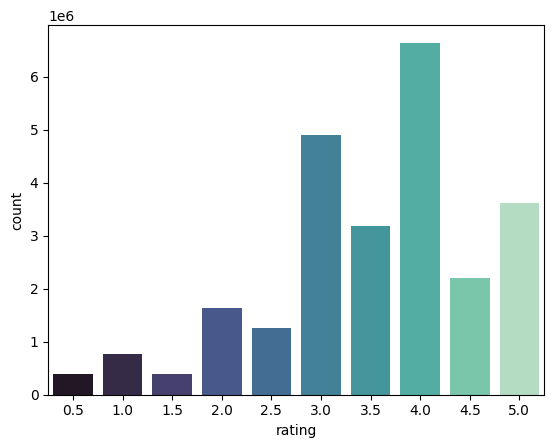

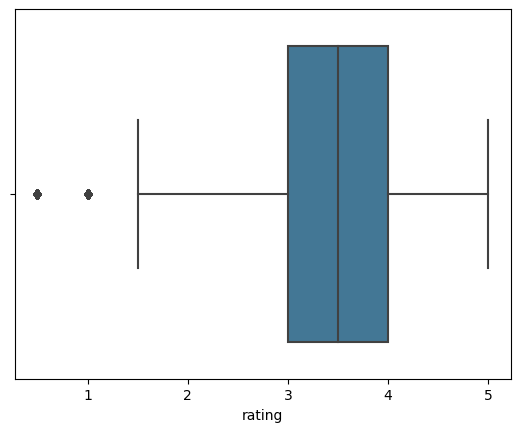

In [11]:
# rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings, palette='mako')
plt.show()

sns.boxplot(x='rating', data=ratings, palette='mako')
plt.show()


Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

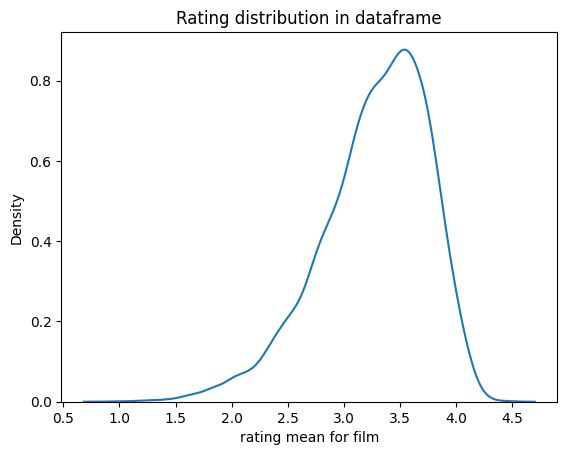

In [12]:
df = datasets[0]['data']

# rating distribution from df
sns.kdeplot(df['mean_rating'], palette='mako')
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()


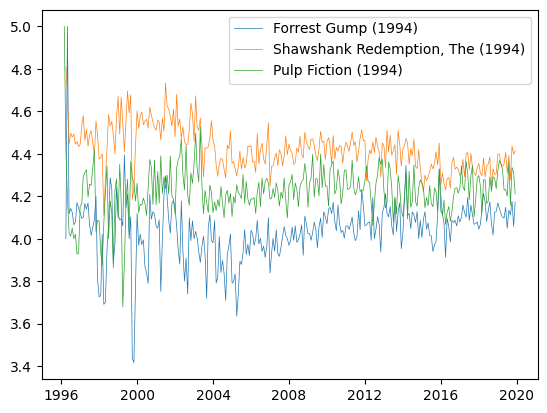

In [13]:
movies_to_show = 3

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

for i in range(movies_to_show):
    data = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    data['date'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Computing the mean for each month
    data = data.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    data['title'] = movie_title
    
    # Visualization
    x = data.index
    y = data['rating']
    plt.plot(x, y, label=movie_title, linewidth=0.5)

plt.legend()
plt.show()

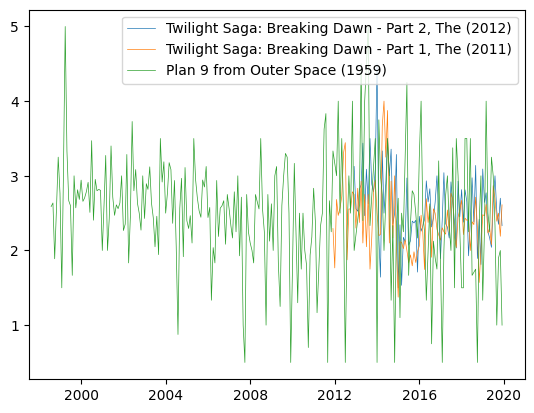

In [14]:
# Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    data = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    data['date'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Computing the mean for each month
    data = data.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    
    # Visualization
    x = data.index
    y = data['rating']
    plt.plot(x, y, label=movie_title, linewidth=0.5)

# Print the titles of the movies
plt.legend()
plt.show()

Plot density for every attribute of dataset

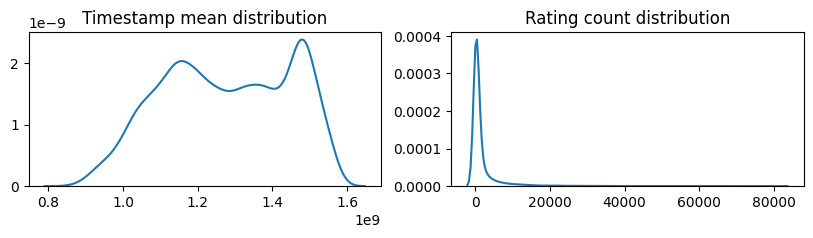

In [15]:
df = datasets[0]['data']

# print distribution for ratings
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
sns.kdeplot(df['mean_timestamp'], ax=axs[0], palette='mako', label='timestamp')
sns.kdeplot(df['rating_count'], ax=axs[1], palette='mako', label='rating')

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].title.set_text('Timestamp mean distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].title.set_text('Rating count distribution')
plt.show()


Number of movies with rating_count < 50:  642
Number of all movies:  13816


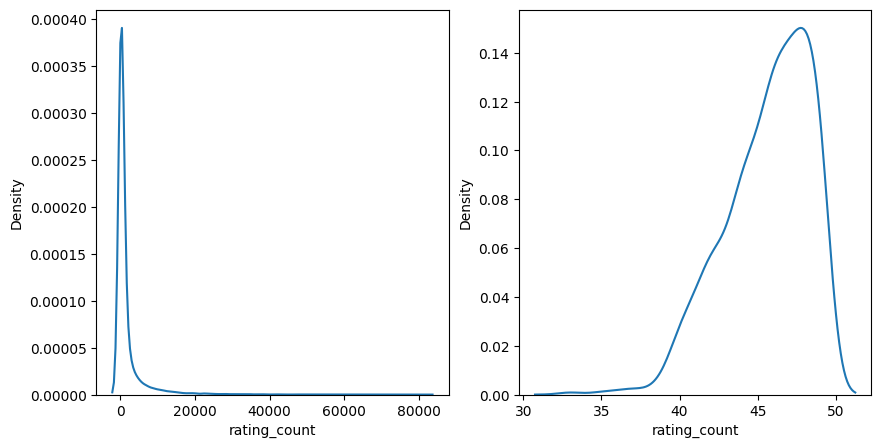

In [16]:
df = datasets[0]['data']

# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count', palette='mako')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50', palette='mako')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0])


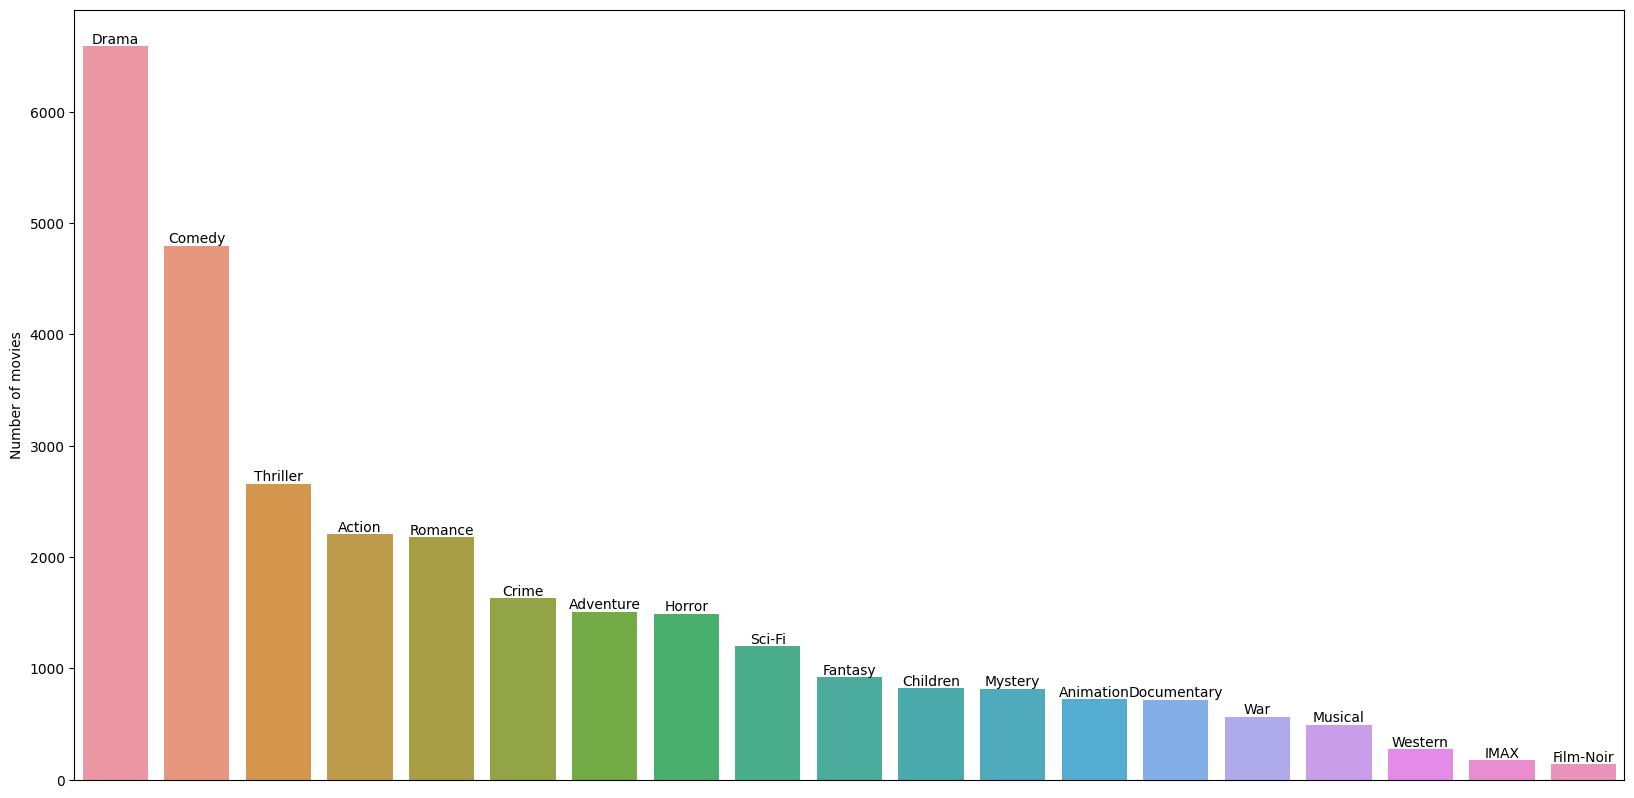

In [17]:
df = datasets[0]['data']

# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
ax.set_ylabel('Number of movies')
plt.xticks([])
plt.show()


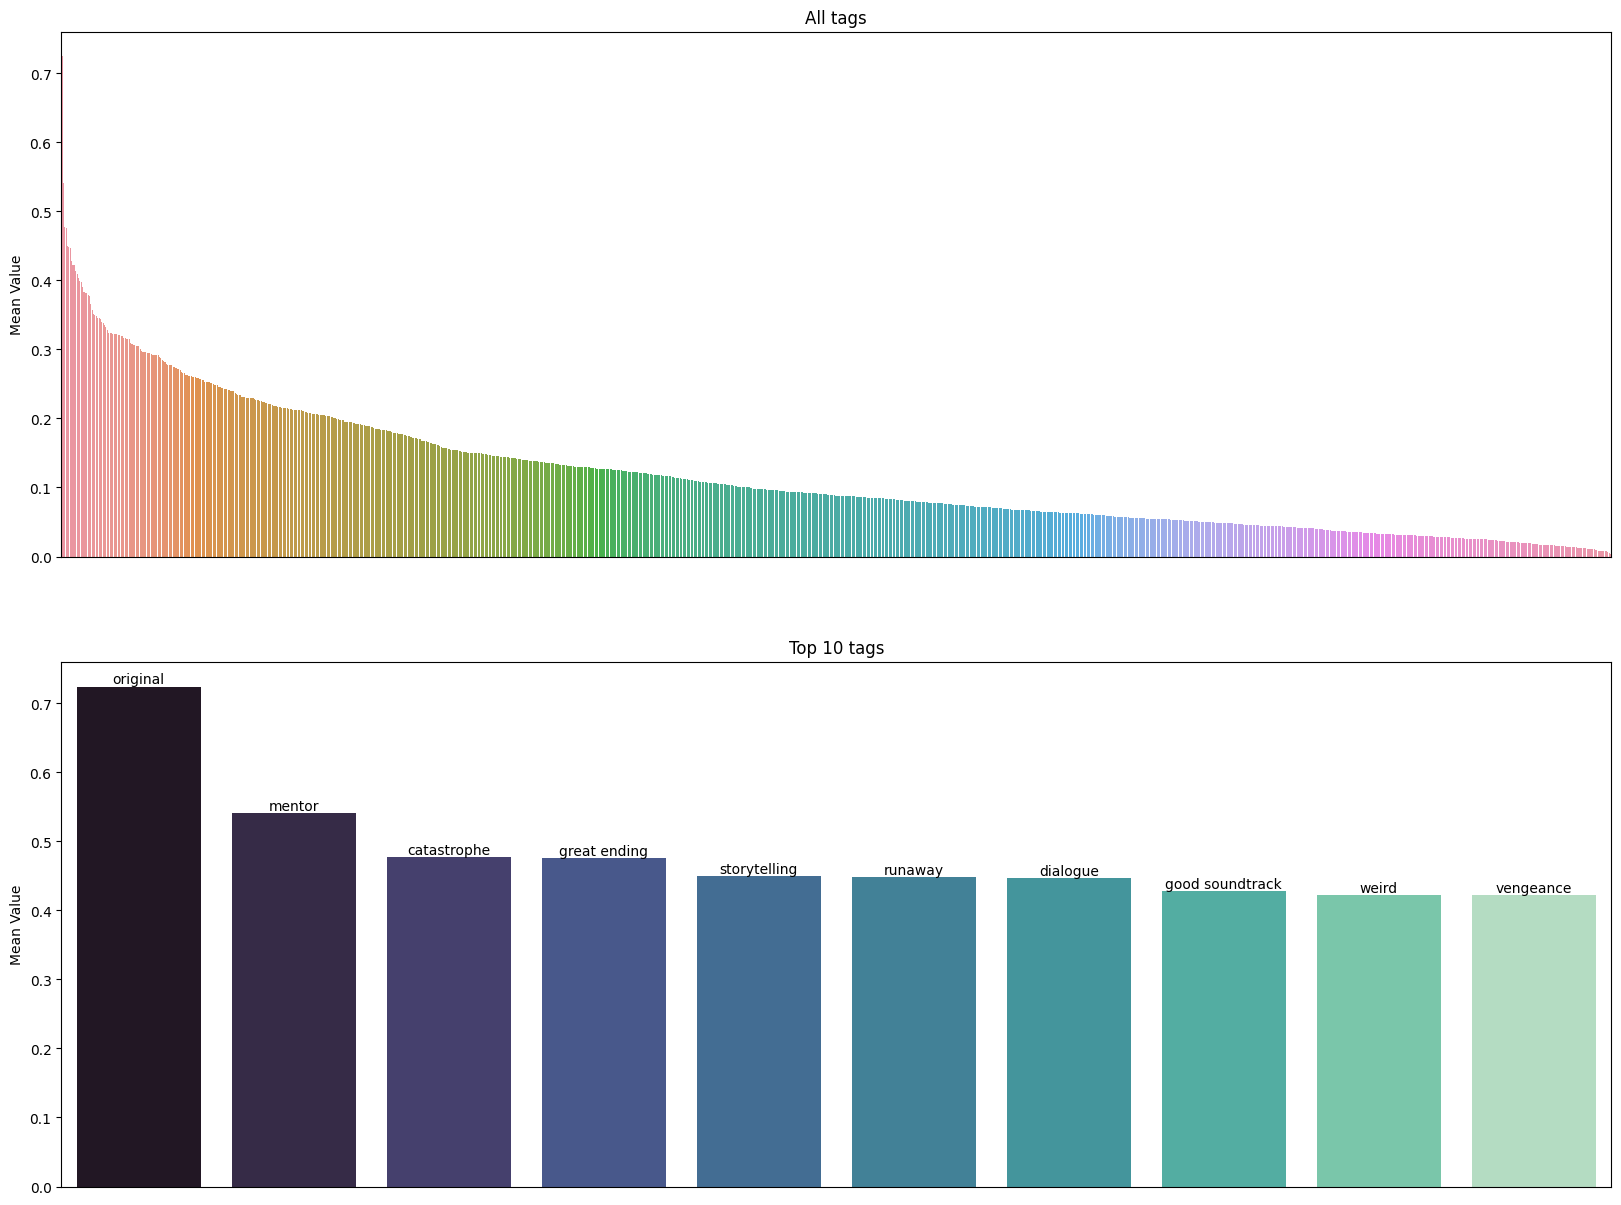

In [18]:
df = datasets[0]['data']

# plot for tags

tag_columns = list(df.columns)
tag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns
tag_columns = [tag for tag in tag_columns if tag not in categories]

tag_dict = {}
for tag in tag_columns:
    tag_dict[tag] = df[tag].mean()

# order the dictionary by value in descending order and plot the first 10
tag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}

fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax1 = sns.barplot(x=list(tag_dict.keys())[:], y=list(tag_dict.values())[:] , ax=axs[0])
ax1.xaxis.set_ticks([])
ax1.set_title('All tags')
ax1.set_ylabel('Mean Value')
ax2 = sns.barplot(x=list(tag_dict.keys())[:10], y=list(tag_dict.values())[:10] , ax=axs[1], palette='mako')
ax2.bar_label(container=ax2.containers[0], labels=list(tag_dict.keys())[:10])
ax2.set_title('Top 10 tags')
ax2.set_ylabel('Mean Value')
plt.xticks([])
plt.show()


In [19]:
df = datasets[0]['data']

# count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum())

Number of Film-Noir movies:  138
Number of IMAX movies:  173


## Data Preprocessing

In [20]:
n = len(datasets)
for i in range(n):

    dataset = datasets[i]
    df = dataset['data']

    df_title = df['title']

    df = df.drop(columns=['movieId', 'title'])

    # from title extract year
    df['year'] = df_title.str.extract('(\(\d{4}\))', expand=True)
    # remove parentheses
    df['year'] = df['year'].str.extract('(\d{4})', expand=True)

    # remove movies with no year
    df = df.dropna(subset=['year'])

    # convert year to int
    df['year'] = df['year'].astype(int)

    datasets[i]['data'] = df
    
    datasets.append({'transform': dataset['transform'], 'threshold': dataset['threshold'], 'year': True, 'tags': dataset['tags'], 'genres': dataset['genres'], 'data': df, 'X_train': dataset['X_train'], 'X_val': dataset['X_val'], 'X_test': dataset['X_test'], 'y_train': dataset['y_train'], 'y_val': dataset['y_val'], 'y_test': dataset['y_test'], 'pca': dataset['pca']})

# remove datasets without year
datasets = datasets[n:]


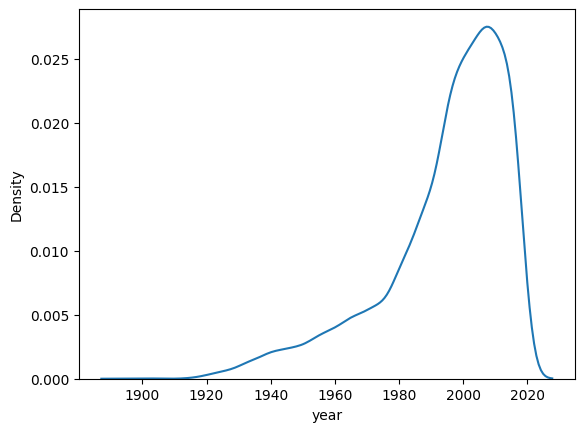

In [21]:
df = datasets[0]['data']

# density plot for film year
sns.kdeplot(df['year'], palette='mako')
plt.show()


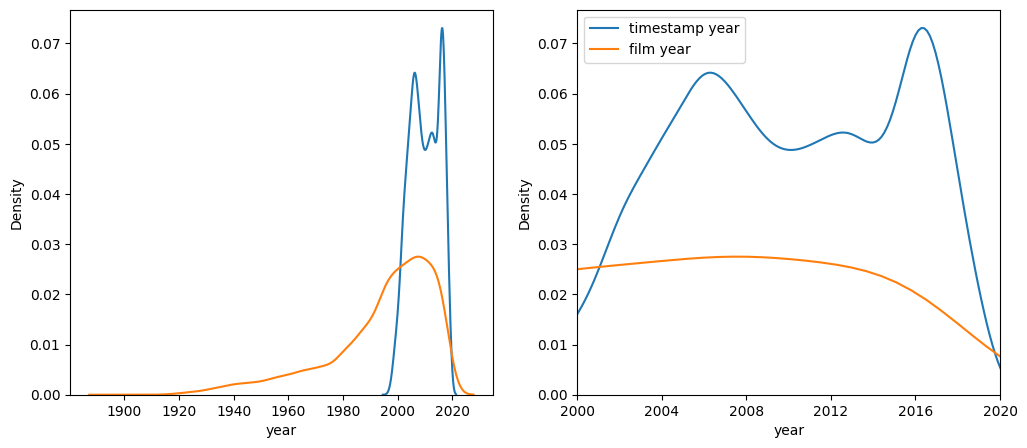

In [22]:
df = datasets[0]['data']

# show year and year_timestamp in the same plot
df_year = df.copy()
df_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')
df_year['year_timestamp'] = df_year['mean_timestamp'].dt.year

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year', palette='mako')
sns.kdeplot(df_year['year'], ax=axs[0], label='film year', palette='mako')
axs[0].set_xlabel('year')
axs[0].set_label('year')
sns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year', palette='mako')
sns.kdeplot(df_year['year'], ax=axs[1], label='film year', palette='mako')
axs[1].set_xlabel('year')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
axs[1].set_label('year_timestamp')
plt.legend()
plt.show()


### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

<!-- Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production. -->

### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

<!-- In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes. -->

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. 

<!-- According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96. -->

<!-- The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09. -->

corr['year']:  -0.1540474820903871
corr['mean_timestamp']:  0.1369066181112574
corr['rating_count']:  0.20276809220561076


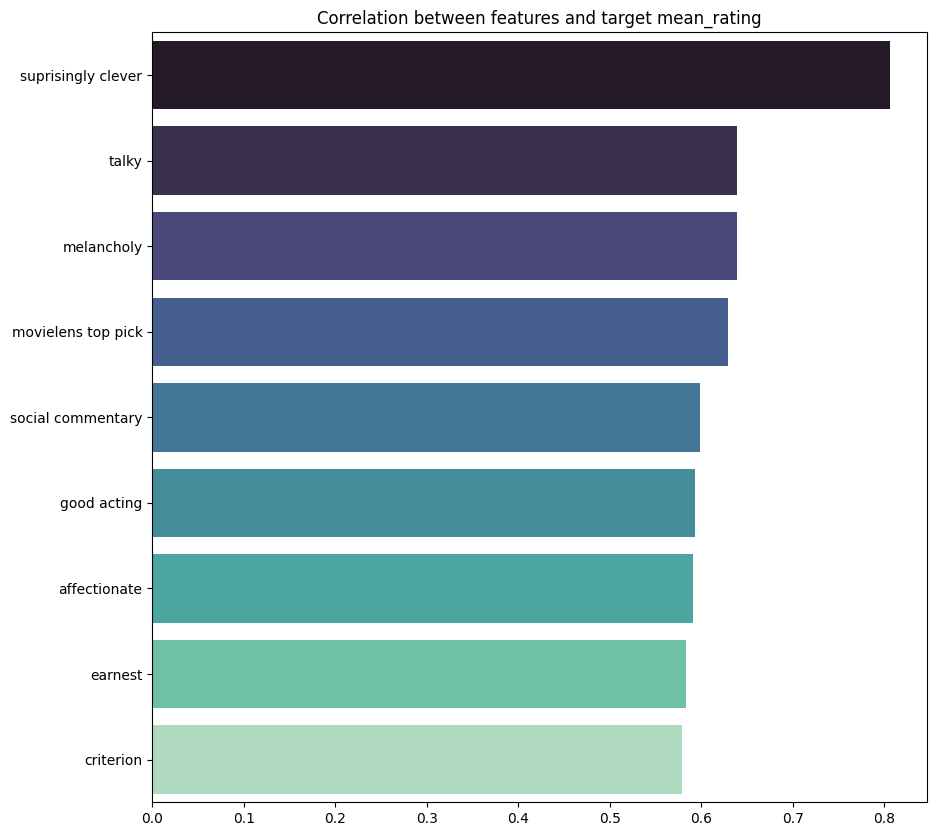

In [23]:
df = datasets[0]['data']

# plot correlation between features and target mean_rating
corr = df.corr()['mean_rating'].sort_values(ascending=False)

print("corr['year']: ", corr['year'])
print("corr['mean_timestamp']: ", corr['mean_timestamp'])
print("corr['rating_count']: ", corr['rating_count'])

# barplot features with highest correlation
plt.figure(figsize=(10, 10))
sns.barplot(x=corr[1:10].values, y=corr[1:10].index, palette='mako')
plt.title('Correlation between features and target mean_rating')
plt.show()

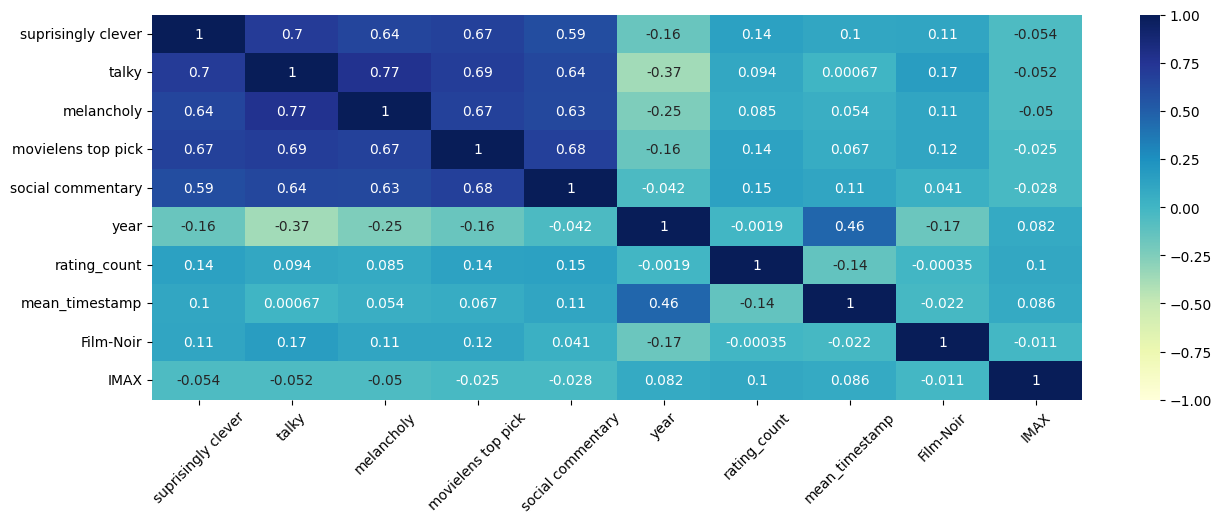

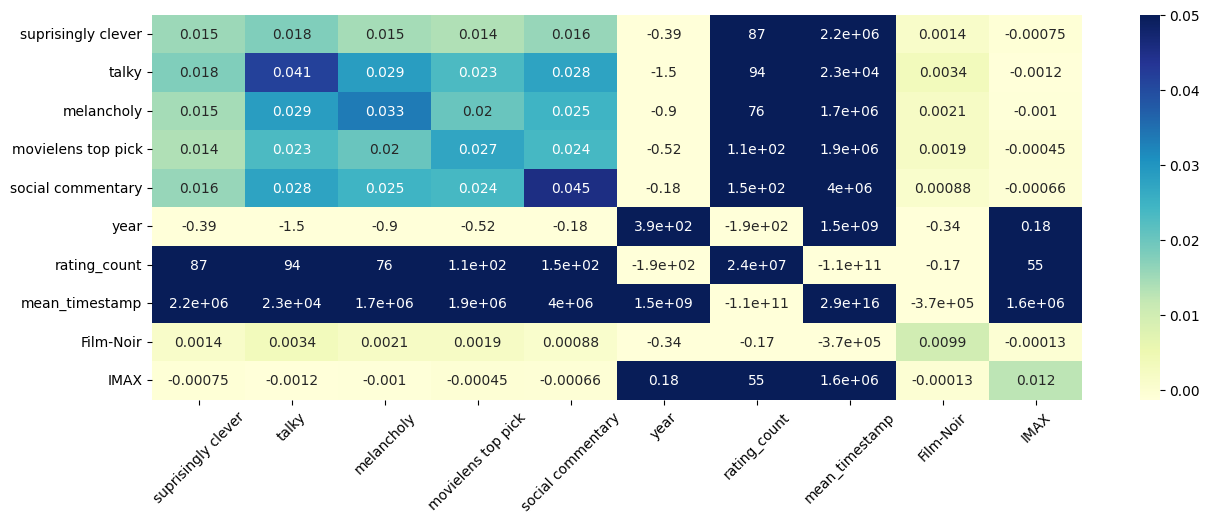

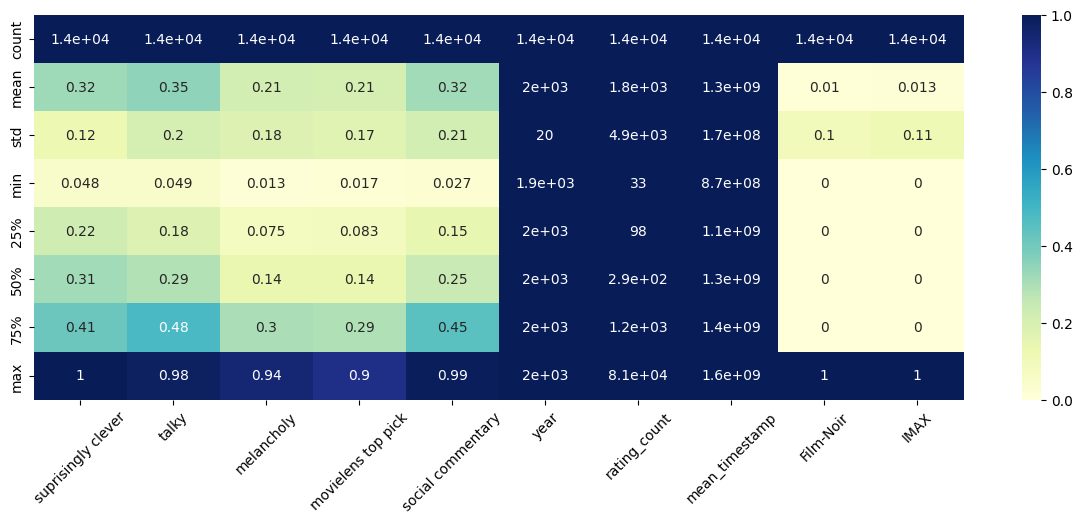

In [24]:
df = datasets[0]['data']

# compute analysis for 'mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX' and first 10 tags based on correlation
list_to_compute = list(corr[1:6].index)
list_to_compute.append('year')
list_to_compute.append('rating_count')
list_to_compute.append('mean_timestamp')
list_to_compute.append('Film-Noir')
list_to_compute.append('IMAX')

corr = df[list_to_compute].corr()
cov = df[list_to_compute].cov()
desc = df[list_to_compute].describe()

plt.figure(figsize=(15, 5))
sns.heatmap(corr, annot=True, cmap="YlGnBu", vmax=1, vmin=-1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 5))
sns.heatmap(cov, annot=True, cmap="YlGnBu", vmax=-0.0012, vmin=0.05)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 5))
sns.heatmap(desc, annot=True, cmap='YlGnBu', vmax=1, vmin=0)
plt.xticks(rotation=45)
plt.show()


### Transformation

In [27]:
columns_to_transform = ['year', 'mean_timestamp', 'rating_count']


def transform(X, type, X_train=None):
    match type:
        case 'L1_normalization':
            X_norm1 = np.linalg.norm(X, ord=1)
            X = X / X_norm1
        case 'L2_normalization':
            X_norm2 = np.linalg.norm(X, ord=2)
            X = X / X_norm2
        case 'sign_sqrt_normalization':
            X = np.sign(X) * np.sqrt(np.abs(X))
        case 'MinMaxScaler':
            X_min = np.min(X_train)
            X_max = np.max(X_train)
            X = (X - X_min) / (X_max - X_min)
        case 'Standardization':
            X_mean = np.mean(X_train)
            X_std = np.std(X_train)
            X = (X - X_mean) / X_std
        case _:
            X = X.astype(float)
    return X


def split_data(df, mean_rating_column):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df, mean_rating_column, test_size=0.2, random_state=42)
    X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=42)
    return X_train_s, X_val_s, X_test_s, y_train_s, y_val_s, y_test_s


# create df from X_train, X_val, X_test, y_train, y_val, y_test
def create_df(X_train, X_val, X_test, y_train, y_val, y_test):
    df = pd.concat([X_train, X_val, X_test], axis=0)
    df = df.reset_index(drop=True)
    df['mean_rating'] = pd.concat([y_train, y_val, y_test], axis=0)
    df = df.reset_index(drop=True)
    return df


def normalize(df, mean_rating_column, type, i):
    print(type)
    for column in columns_to_transform:
        df[column] = transform(df[column], type)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, mean_rating_column)
    df = create_df(X_train, X_val, X_test, y_train, y_val, y_test)
    datasets.append({'transform': type, 'threshold': datasets[i]['threshold'], 'year': datasets[i]['year'], 'tags': datasets[i]['tags'], 'genres': datasets[i]['genres'], 'data': df, 'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test, 'pca': datasets[i]['pca']})


def standardize(df, mean_rating_column, type, i):
    print(type)
    X_train_s, X_val, X_test, y_train, y_val, y_test = split_data(df, mean_rating_column)
    X_train = copy.deepcopy(X_train_s)
    for column in columns_to_transform:
        X_train[column] = transform(X_train[column], type, X_train_s[column])
        X_val[column] = transform(X_val[column], type, X_train_s[column])
        X_test[column] = transform(X_test[column], type, X_train_s[column])
    df = create_df(X_train, X_val, X_test, y_train, y_val, y_test)
    datasets.append({'transform': type, 'threshold': datasets[i]['threshold'], 'year': datasets[i]['year'], 'tags': datasets[i]['tags'], 'genres': datasets[i]['genres'], 'data': df, 'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test, 'pca': datasets[i]['pca']})


n = len(datasets)
for i in range(n):
    print('Dataset {}/{}'.format(i+1, n), end='\r')
    dataset = datasets[i]

    np.random.seed(42)
    df_general = dataset['data']
    mean_rating_column = df_general['mean_rating']
    df_general = df_general.drop(columns=['mean_rating'])

    # L2 normalization
    df = copy.deepcopy(df_general)
    normalize(df, mean_rating_column, 'L2_normalization', i)

    # Sign Square Rooted normalization
    df = copy.deepcopy(df_general)
    normalize(df, mean_rating_column, 'sign_sqrt_normalization', i)

    # L1 normalization
    df = copy.deepcopy(df_general)
    normalize(df, mean_rating_column, 'L1_normalization', i)

    # MinMaxScaler
    df = copy.deepcopy(df_general)
    standardize(df, mean_rating_column, 'MinMaxScaler', i)
    
    # Standardization
    df = copy.deepcopy(df_general)
    standardize(df, mean_rating_column, 'Standardization', i)

    # None : transform int columns to float columns
    df = copy.deepcopy(df_general)
    normalize(df, mean_rating_column, 'None', i)


# remove datasets without transformation
datasets = datasets[n:]

L2_normalization
sign_sqrt_normalization
L1_normalization
MinMaxScaler
Standardization
None


### TSNE

In [26]:
""" X_train = datasets[0]['X_train']
perplexities = [5, 30, 50, 100]
tsne = [None] * len(perplexities)
X_train_TSNE = [None] * len(perplexities)
for i, p in enumerate(perplexities):
    print('Perplexity: {}'.format(p))
    tsne[i] = TSNE(n_components=2, init='random', random_state=42, perplexity=p)
    tsne[i] = tsne[i].fit(X_train)
    X_train_TSNE[i] = tsne[i].fit_transform(X_train)
y_train = datasets[0]['y_train']
 """

Perplexity: 5
Perplexity: 30
Perplexity: 50
Perplexity: 100


In [27]:
""" fig, axs = plt.subplots(len(perplexities), 1, figsize=(10, 25))
for i, p in enumerate(perplexities):
    fig.colorbar(axs[i].scatter(X_train_TSNE[i][:, 0], X_train_TSNE[i][:, 1], c=y_train, cmap='mako', s=5), ax=axs[i])
    axs[i].set_title('Perplexity: {}'.format(p))
plt.show() """

" fig, axs = plt.subplots(len(perplexities), 1, figsize=(10, 25))\nfor i, p in enumerate(perplexities):\n    fig.colorbar(axs[i].scatter(X_train_TSNE[i][:, 0], X_train_TSNE[i][:, 1], c=y_train, cmap='mako', s=5), ax=axs[i])\n    axs[i].set_title('Perplexity: {}'.format(p))\nplt.show() "

## Modeling

In [28]:
def plot_model_results(hgs, model_name):
    # get all scores of candidates over iterations
    hgs_results = pd.DataFrame(hgs.cv_results_)

    # drop rows with iter < max
    hgs_results = hgs_results[hgs_results['iter'] == hgs_results['iter'].max()]
    # drop all columns except mean_test_score, iter and those that start with 'param_'
    hgs_results = hgs_results[[col for col in hgs_results.columns if col.startswith('param_') or col in ['iter','mean_test_score']]]
    # set param_n_jobs to 8 instead of -1
    hgs_results['param_n_jobs'] = 8
    # rename mean_test_score to mse and transform to positive
    if model_name == 'RandomForestClassification':
        hgs_results['accuracy'] = hgs_results['mean_test_score']
        hgs_results = hgs_results.sort_values(by='accuracy')
    else:
        hgs_results['mse'] = -hgs_results['mean_test_score']
        hgs_results = hgs_results.sort_values(by='mse')
    hgs_results = hgs_results.drop('mean_test_score', axis=1)
    hgs_results = hgs_results.reset_index(drop=True)
    display(hgs_results)


    # add results to tensorboard
    writer = SummaryWriter('based_models/{}'.format(model_name))
    # for all rows add mse column as scalar and columns that start with param_ as hparams
    for _, row in hgs_results.iterrows():
        hparams = {key: str(value) for key, value in row.items() if key.startswith('param_')}
        if model_name == 'RandomForestClassification':
            writer.add_hparams(hparams, {'accuracy': row['accuracy']})
        else:
            writer.add_hparams(hparams, {'mse': row['mse']})
        writer.flush()
    writer.close()
    

    return hgs_results


In [29]:
dataset = datasets[0]

print('\nTransform: {}, Threshold: {}, Year: {}, Tags: {}, Genres: {}, PCA: {}'.format(dataset['transform'], dataset['threshold'], dataset['year'], dataset['tags'], dataset['genres'], dataset['pca']))

X_train = dataset['X_train']
X_val = dataset['X_val']
X_test = dataset['X_test']
y_train = dataset['y_train']
y_val = dataset['y_val']
y_test = dataset['y_test']



Transform: L2_normalization, Threshold: 0.0, Year: True, Tags: True, Genres: True, PCA: False


#### Linear Regressor

In [30]:
rng = np.random.RandomState(0)

model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))

hgs_results = plot_model_results(hgs, 'LinearRegression')


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 2943
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 2943
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.043, test=-0.049) total time=   1.3s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.047, test=-0.044) total time=   1.1s
[CV 3/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.052, test=-0.046) total time=   1.0s
[CV 4/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.047, test=-0.052) total time=   1.2s
[CV 5/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.046, test=-0.049) total time=   1.0s
[CV 1/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.002, test=-0.010) total time=   0.6s
[CV 2/5] END copy_X=True, fit_intercept=True, po

,iter,param_copy_X,param_fit_intercept,param_positive,param_n_jobs,mse
0,1,True,True,False,8,0.005574
1,1,False,True,False,8,0.005574
2,1,False,False,False,8,0.005904


#### SVM

In [31]:
# use HalvingGridSearchCV to find the best parameters for SVM

rng = np.random.RandomState(0)

model = SVR()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.5],
    'tol': [1e-3, 1e-6],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1, 1, 10],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))

hgs_results = plot_model_results(hgs, 'SVR')


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 12
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 12
Fitting 2 folds for each of 1600 candidates, totalling 3200 fits
[CV 1/2] END C=0.001, coef0=0.0, degree=2, epsilon=0.001, gamma=scale, kernel=linear, tol=0.001;, score=(train=-0.122, test=-0.244) total time=   0.0s
[CV 2/2] END C=0.001, coef0=0.0, degree=2, epsilon=0.001, gamma=scale, kernel=linear, tol=0.001;, score=(train=-0.294, test=-0.150) total time=   0.0s
[CV 1/2] END C=0.001, coef0=0.0, degree=2, epsilon=0.001, gamma=scale, kernel=linear, tol=1e-06;, score=(train=-0.122, test=-0.244) total time=   0.0s
[CV 2/2] END C=0.001, coef0=0.0, degree=2, epsilon=0.001, gamma=scale, kernel=linear, tol=1e-06;, score=(train=-0.294, test=-0.150) total time=   0.0s
[CV 1/2] END C=0.001, coef0=0.0, degree=2, epsilon=0.001, gamma=scale, kernel=poly, tol=0.001;, score=(train=-0.134, test=-0.249) t

,iter,param_C,param_coef0,param_degree,param_epsilon,param_gamma,param_kernel,param_tol,param_n_jobs,mse
0,6,10,0.0,2,0.01,auto,rbf,0.000001,8,0.005694
1,6,10,0.5,2,0.01,auto,rbf,0.000001,8,0.005694
2,6,10,0.0,5,0.01,auto,rbf,0.000001,8,0.005694


### KNN

In [32]:
# use HalvingGridSearchCV to find the best parameters for KNN

rng = np.random.RandomState(0)

model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.arange(1, 21),
    'weights': ['uniform', 'distance']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'KNeighborsRegressor')


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 327
Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2] END n_neighbors=1, weights=uniform;, score=(train=-0.000, test=-0.155) total time=   0.1s
[CV 2/2] END n_neighbors=1, weights=uniform;, score=(train=-0.000, test=-0.116) total time=   0.0s
[CV 1/2] END n_neighbors=1, weights=distance;, score=(train=-0.000, test=-0.155) total time=   0.0s
[CV 2/2] END n_neighbors=1, weights=distance;, score=(train=-0.000, test=-0.116) total time=   0.0s
[CV 1/2] END n_neighbors=2, weights=uniform;, score=(train=-0.036, test=-0.113) total time=   0.0s
[CV 2/2] END n_neighbors=2, weights=uniform;, score=(train=-0.054, test=-0.086) total time=   0.0s
[CV 1/2] END n_neighbors=2, weights=distance;, score=(train=-0.000, test=-0.113) total time=   0.0s
[CV 2/2] END n_neighbors=2, weights=distanc

,iter,param_n_neighbors,param_weights,param_n_jobs,mse
0,3,9,distance,8,0.053098
1,3,7,distance,8,0.053509


### Decision Trees

In [33]:
# use HalvingGridSearchCV to find the best parameters for Decision Tree

rng = np.random.RandomState(0)

model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'DecisionTreeRegressor')




n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 109
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 109
Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV 1/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=(train=-0.015, test=-0.108) total time=   0.0s
[CV 2/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=(train=-0.015, test=-0.089) total time=   0.0s
[CV 1/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4;, score=(train=-0.015, test=-0.095) total time=   0.0s
[CV 2/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4;, score=(train=-0.015, test=-0.082) total time=   0.0s
[CV 1/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6;, score=(train=-0.020, test=-0.098) total time=   0.0s
[CV 2/2] END max_depth=3, max_features

,iter,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_jobs,mse
0,4,5,auto,1,2,8,0.036196


### Ridge

In [34]:
# use HalvingGridSearchCV to find the best parameters for Ridge Regression

rng = np.random.RandomState(0)

model = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'Ridge')



n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 2943
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 2943
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END ...alpha=0.1;, score=(train=-0.001, test=-0.013) total time=   0.1s
[CV 2/2] END ...alpha=0.1;, score=(train=-0.001, test=-0.014) total time=   0.2s
[CV 1/2] END .....alpha=1;, score=(train=-0.002, test=-0.008) total time=   0.2s
[CV 2/2] END .....alpha=1;, score=(train=-0.002, test=-0.008) total time=   0.2s
[CV 1/2] END ....alpha=10;, score=(train=-0.004, test=-0.008) total time=   0.2s
[CV 2/2] END ....alpha=10;, score=(train=-0.005, test=-0.009) total time=   0.1s
----------
iter: 1
n_candidates: 1
n_resources: 8829
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END .....alpha=1;, score=(train=-0.003, test=-0.006) total time=   0.3s
[CV 2/2] END .....alpha=1;, score=(train=-0.003, test=-0.006)

,iter,param_alpha,param_n_jobs,mse
0,1,1,8,0.006077


### Lasso

In [35]:
# use HalvingGridSearchCV to find the best parameters for Lasso Regression

rng = np.random.RandomState(0)

model = Lasso()

param_grid = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [100, 1000, 10000],
    'fit_intercept': [True, False],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'Lasso')


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 327
Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END alpha=0.1, fit_intercept=True, max_iter=100;, score=(train=-0.236, test=-0.215) total time=   0.0s
[CV 2/2] END alpha=0.1, fit_intercept=True, max_iter=100;, score=(train=-0.265, test=-0.185) total time=   0.1s
[CV 1/2] END alpha=0.1, fit_intercept=True, max_iter=1000;, score=(train=-0.236, test=-0.215) total time=   0.1s
[CV 2/2] END alpha=0.1, fit_intercept=True, max_iter=1000;, score=(train=-0.265, test=-0.185) total time=   0.1s
[CV 1/2] END alpha=0.1, fit_intercept=True, max_iter=10000;, score=(train=-0.236, test=-0.215) total time=   0.1s
[CV 2/2] END alpha=0.1, fit_intercept=True, max_iter=10000;, score=(train=-0.265, test=-0.185) total time=   0.1s
[CV 1/2] END alpha=0.1, fit_intercept=False, max_iter=100;, s

,iter,param_alpha,param_fit_intercept,param_max_iter,param_n_jobs,mse
0,3,0.0001,True,10000,8,0.005858
1,3,0.0001,True,1000,8,0.005867


### ElasticNet

In [36]:
# use HalvingGridSearchCV to find the best parameters for ElasticNet Regression

rng = np.random.RandomState(0)

model = ElasticNet()

param_grid = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'l1_ratio': [0.1, 0.5, 0.9],
    'max_iter': [100, 1000, 10000],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'ElasticNet')



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 327
Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END alpha=0.1, l1_ratio=0.1, max_iter=100;, score=(train=-0.061, test=-0.058) total time=   0.0s
[CV 2/2] END alpha=0.1, l1_ratio=0.1, max_iter=100;, score=(train=-0.061, test=-0.053) total time=   0.0s
[CV 1/2] END alpha=0.1, l1_ratio=0.1, max_iter=1000;, score=(train=-0.061, test=-0.058) total time=   0.0s
[CV 2/2] END alpha=0.1, l1_ratio=0.1, max_iter=1000;, score=(train=-0.061, test=-0.053) total time=   0.0s
[CV 1/2] END alpha=0.1, l1_ratio=0.1, max_iter=10000;, score=(train=-0.061, test=-0.058) total time=   0.1s
[CV 2/2] END alpha=0.1, l1_ratio=0.1, max_iter=10000;, score=(train=-0.061, test=-0.053) total time=   0.0s
[CV 1/2] END alpha=0.1, l1_ratio=0.5, max_iter=100;, score=(train=-0.181, test=-0.172) total tim

,iter,param_alpha,param_l1_ratio,param_max_iter,param_n_jobs,mse
0,3,0.001,0.1,10000,8,0.006069
1,3,0.001,0.1,1000,8,0.006104


### Random Forest Regressor

In [37]:
# use HalvingGridSearchCV to find the best parameters for Random Forest Regression

rng = np.random.RandomState(0)

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'RandomForestRegressor')


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 327
Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-0.013, test=-0.044) total time=   0.3s
[CV 2/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-0.007, test=-0.032) total time=   0.3s
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=-0.007, test=-0.033) total time=   1.3s
[CV 2/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=-0.008, test=-0.032) total time=   1.3s
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score

,iter,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,mse
0,3,5,auto,2,2,100,8,0.022672
1,3,5,auto,1,4,100,8,0.022704


### Modeling the problem as classification

In [38]:
# bin y_train and y_test into 10 bins
y_train_binned = pd.cut(y_train, 10, labels=False)
y_test_binned = pd.cut(y_test, 10, labels=False)

# use HalvingGridSearchCV to find the best parameters for Random Forest Classification
rng = np.random.RandomState(0)

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='accuracy'
)
hgs.fit(X_train, y_train_binned)



print("\nBest Accuracy: {:.6f}".format(hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'RandomForestClassification')


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 327
Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.982, test=0.509) total time=   0.0s
[CV 2/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.975, test=0.491) total time=   0.0s
[CV 1/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.583) total time=   0.1s
[CV 2/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=1.000, test=0.613) total time=   0.1s
[CV 1/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100;

,iter,param_criterion,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,accuracy
0,3,entropy,sqrt,4,5,100,8,0.706729
1,3,entropy,sqrt,1,5,100,8,0.709674


### Neural Network

In [39]:
# Selection of the dataset to test
i = 0

X_train = datasets[i]['X_train']
y_train = datasets[i]['y_train']
X_test = datasets[i]['X_test']
y_test = datasets[i]['y_test']
X_val = datasets[i]['X_val']
y_val = datasets[i]['y_val']

In [40]:
#look for GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))


Device: cpu


In [41]:
# Fix random seed
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)


In [42]:
# Definition of the training process
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, writer):
    patience = 10
    best_loss = np.inf
    best_model = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        mean_loss = 0
        # per verificare che ci troviamo in training e non in validation per evitare che il modello aggiorni i pesi
        for data, targets in data_loader:
            # per spostare il minibatch in GPU
            data, targets = data.to(device), targets.to(device)
            # Forward pass -> chiama la funzione forward
            y_pred = model(data)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            mean_loss += loss.item()
            # serve per azzerare il gradiente
            optimizer.zero_grad()
            # la barra separa Loss e la sezione train
            # Backward pass
            loss.backward()
            optimizer.step()
        writer.add_scalar("Loss/train", mean_loss/len(data_loader), epoch)

        
        # validation
        loss_val, _, _ = test_model(model, criterion, val_loader, device)

        # early stopping
        if loss_val <= best_loss:
            best_loss = loss_val
            best_model = copy.deepcopy(model)
            best_epoch = epoch+1
            patience = 10
        else:
            patience = patience - 1
            if patience == 0:
                print("\nEarly stopping", end='')
                return best_model, best_epoch

        if best_loss == np.inf:
            print("No validation loss available", end='\n')
            return model, epoch
        
        print("Epoch: [ {} / {} ],\tPatience: {},\tBest loss: {:.4f},\tVal Loss: {:.4f}".format(epoch+1, epochs, patience, best_loss, loss_val), end='\r')
        writer.add_scalar("Loss/val", loss_val, epoch)
    
    return best_model, best_epoch



#evaluation process -> utilizzata sia per la validation che per il test
def test_model(model, criterion, data_loader, device):
    model.eval() # per evitare che il modello aggiorni i pesi
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        loss += criterion(output.squeeze(), targets)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, targets), 0)

    return loss/len(data_loader), y_pred.squeeze(), y_true

In [43]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dp = dropout_prob
        
        model = [
            nn.Linear(self.input_size, self.hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(self.dp)
        ]
        
        for i in range(1, len(self.hidden_sizes)):
            model.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            model.append(nn.ReLU())
            model.append(nn.Dropout(self.dp))
        
        model.append(nn.Linear(self.hidden_sizes[-1], 1))
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()


In [44]:
class RatingDataset(Dataset):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        
        self.num_features = X_train.shape[1]
        
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_val = X_val.to_numpy()
        self.y_val = y_val.to_numpy()
        self.X_test = X_test.to_numpy()
        self.y_test = y_test.to_numpy()
        
        self.num_samples = len(X_train)

        self.val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=self.num_samples, shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=self.num_samples, shuffle=False)
    
    def get_train_loader(self, batch_size):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_train, dtype=torch.float32), torch.tensor(self.y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    
    def get_val_test_loaders(self, batch_size):
        val = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
        test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
        return val, test

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]


In [45]:
# Setting Hyperparameters
hidden_sizes = [[64, 128, 64]]
batch_sizes = [32]
learning_rate = [0.001]
dropout_prob = [0.0]

nums_epochs = [200]
scheduler_step_size = [10]
scheduler_gamma = [0.1]
val_test_batch_sizes = [X_train.shape[0]]

hyperparameters = itertools.product(hidden_sizes, nums_epochs, batch_sizes, learning_rate, dropout_prob, val_test_batch_sizes, scheduler_step_size, scheduler_gamma)


In [46]:
# data
my_dataset = RatingDataset(X_train, y_train, X_val, y_val, X_test, y_test)

my_table = pd.DataFrame(columns=['hidden_size', 'num_epochs', 'batch_size', 'learning_rate', 'dropout_prob', 'MSE', 'R2'])

#grid search loop
for i, [hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size, scheduler_step_size, scheduler_gamma] in enumerate(hyperparameters):
    
    val_loader, test_loader = my_dataset.get_val_test_loaders(val_test_batch_size)
    print("Iter: {}, hidden_size: {}, num_epochs: {}, batch_size: {}, learning_rate: {}, dropout_prob: {}, val_test_batch_size: {}, scheduler_step_size: {}, scheduler_gamma: {}".format(i+1, hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size, scheduler_step_size, scheduler_gamma))

    log_name = "dim:"+str(hidden_size)+"-ep:"+str(num_epochs)+"-bs:"+str(batch) + "-lr:"+str(learning_rate) + "-dp:"+str(dropout_prob)

    train_loader = my_dataset.get_train_loader(batch)

    model = NN(my_dataset.num_features, hidden_size, dropout_prob)

    criterion = torch.nn.MSELoss()

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    
    writer = SummaryWriter('runs/'+log_name)

    model, n_epochs = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)

    mse, y_t, y_p = test_model(model, criterion, test_loader, device)
    r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
    print("\nMSE: ", mse.item())
    print("R2: {}".format(r2))
    
    
    my_table.loc[my_table.shape[0]] = [hidden_size, n_epochs, batch, learning_rate, dropout_prob, mse.item(), r2]
    writer.add_scalar('metrics/test mse', mse.item())
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), 'models/'+log_name)

    writer.add_hparams(
        {'lr': learning_rate, 'bsize': batch, 'dim': str(hidden_size), 'num_epochs': n_epochs, 'dropout_prob': dropout_prob},
        {'hparam/mse': mse.item(), 'hparam/r2': r2}
    )

    writer.flush()
    
    
writer.close()


Iter: 1, hidden_size: [64, 128, 64], num_epochs: 200, batch_size: 32, learning_rate: 0.001, dropout_prob: 0.0, val_test_batch_size: 8830, scheduler_step_size: 10, scheduler_gamma: 0.1
Epoch: [ 43 / 200 ],	Patience: 1,	Best loss: 0.0057,	Val Loss: 0.00627
Early stopping
MSE:  0.005828032270073891
R2: 0.9743431749994975


In [48]:
# get model with hidden_size = [64, 128, 64], batch_size = 32, learning_rate = 0.001, dropout_prob = 0.0
best_model = NN(my_dataset.num_features, [64, 128, 64], 0.0)
best_model.load_state_dict(torch.load('models/dim:[64, 128, 64]-ep:200-bs:32-lr:0.001-dp:0.0'))
best_model.to(device)

mse, y_t, y_p = test_model(best_model, criterion, test_loader, device)
r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
print("\nMSE: ", mse.item())
print("R2: {}".format(r2))



MSE:  0.005828032270073891
R2: 0.9743431749994975


### TabNet

In [25]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [28]:
df = datasets[1]

X_train = df['X_train'].to_numpy()
X_test = df['X_test'].to_numpy()
X_val = df['X_val'].to_numpy()
y_train = df['y_train'].to_numpy()
y_test = df['y_test'].to_numpy()
y_val = df['y_val'].to_numpy()

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [29]:
# Tuning hyperparameters
# batch_sizes = [128, 256]
# n_a = [8, 16, 32]
# n_d = [8, 16, 32]

# Best configuration found
batch_sizes = [128]
n_a = [16]
n_d = [8]

hyperparameters = list(itertools.product(batch_sizes, n_a, n_d))

In [30]:
""" for bs, na, nd in hyperparameters:
    print(f"Testing configuration batch_size={bs}, n_a={na}, n_d={nd}")
    tabnet_model = TabNetRegressor(
        n_a=na,
        n_d=nd,
        verbose=0
    )

    tabnet_model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_name=['validation'],
        batch_size=bs,
    )
    
    # evaluate model
    y_pred = tabnet_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('MSE:', mse)
    print('R2 Score:', r2)
    print('#'*50)
    print() """

Testing configuration batch_size=128, n_a=16, n_d=8

Early stopping occurred at epoch 37 with best_epoch = 27 and best_validation_mse = 0.00608
MSE: 0.005884382847695725
R2 Score: 0.9739120622551057
##################################################



In [33]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
# saved_filepath = tabnet_model.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_model = TabNetRegressor()
loaded_model.load_model(saving_path_name + ".zip")

In [35]:
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2 Score:', r2)

MSE: 0.005884382847695725
R2 Score: 0.9739120622551057
